In [1]:
import pandas as pd
import numpy as np
import tensorflow as tf
from tensorflow.keras import Sequential
from tensorflow.keras.layers import Conv1D, Dense, Flatten, Embedding, SimpleRNN, Input, Reshape
from tensorflow.keras.preprocessing import sequence
from keras.callbacks import EarlyStopping, ModelCheckpoint, ReduceLROnPlateau
from tensorflow.keras import Model
import matplotlib.pyplot as plt
AUTOTUNE = tf.data.experimental.AUTOTUNE

In [2]:
def convert_to_list(string):
    return [float(i) if i != '' else 0 for i in string.split(', ')]

def process_dataset(df):
    columns = ['time', 'mag', 'flux', 'scaled_mag', 'scaled_flux']
    for i in columns:
        df[i] = df[i].apply(lambda x: x[1:-1])
        df = df[~df[i].isnull()]
        df[i] = df[i].apply(convert_to_list)
    return df

In [3]:
df = pd.read_csv(r'Mini Dataset/final_df_g.csv')
#df =  pd.read_csv('/content/drive/MyDrive/AI - 3 Project/Mini Dataset/final_df_g.csv', index_col = 0)
df = process_dataset(df)
df.reset_index(inplace=True)
df.drop(['index'], axis=1, inplace=True)
df.head(2)

,Unnamed: 0,source_id,band,time,mag,flux,label,scaled_mag,scaled_flux
0,0,1051896903074455936,G,"[1709.0473075002526, 1709.12129661769, 1746.93...","[14.779410003765635, 14.61257323866902, 14.388...","[23077.180413664224, 26910.232583122888, 33064...",CEP,"[0.356576359569324, 0.3630769150306008, 0.3645...","[0.0015727061122589926, 0.0013981080325825006,..."
1,3,1113929871645836672,G,"[1705.0618115528753, 1742.1944699213775, 1781....","[11.034948789103318, 10.976913805916949, 11.27...","[726051.1726333069, 765916.145348983, 580536.1...",CEP,"[0.7278831843177883, 0.7372211180381949, 0.746...","[1.880752403321352e-06, 1.586109917003193e-06,..."


In [9]:
X = df['mag']
y = df[['label']]

In [10]:
from sklearn.preprocessing import LabelEncoder
y = LabelEncoder().fit_transform(y['label'])
print(y)

[0 0 0 ... 3 3 3]


In [11]:
def onehot_encoder(y):
  k = len(np.unique(y))
  return np.eye(k)[y]

In [12]:
y = onehot_encoder(y)

In [13]:
y

array([[1., 0., 0., 0.],
       [1., 0., 0., 0.],
       [1., 0., 0., 0.],
       ...,
       [0., 0., 0., 1.],
       [0., 0., 0., 1.],
       [0., 0., 0., 1.]])

In [14]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.2, random_state = 42)

In [15]:
X_train.shape, y_train.shape, X_test.shape, y_test.shape

((48016,), (48016, 4), (12005,), (12005, 4))

In [16]:
length = [len(i) for i in X_train]
print(max(length))
print(length)

261
[40, 39, 51, 48, 43, 63, 52, 49, 38, 49, 36, 43, 43, 43, 51, 45, 63, 42, 30, 49, 55, 49, 48, 29, 65, 94, 57, 64, 25, 55, 26, 40, 46, 34, 44, 45, 67, 36, 83, 43, 40, 43, 22, 46, 55, 46, 39, 61, 30, 50, 56, 57, 49, 56, 50, 42, 55, 28, 33, 55, 57, 66, 48, 30, 49, 54, 55, 54, 61, 48, 66, 51, 29, 49, 54, 49, 54, 51, 28, 36, 46, 43, 59, 38, 48, 43, 56, 37, 45, 40, 55, 55, 57, 53, 44, 49, 45, 63, 50, 41, 25, 43, 29, 42, 47, 43, 37, 39, 51, 45, 39, 50, 66, 84, 41, 60, 39, 51, 52, 36, 47, 77, 188, 66, 69, 53, 43, 37, 32, 61, 46, 41, 46, 61, 52, 51, 55, 42, 48, 64, 57, 61, 61, 26, 28, 50, 43, 39, 60, 38, 42, 59, 61, 57, 45, 97, 45, 54, 42, 47, 52, 46, 43, 39, 34, 53, 50, 46, 61, 62, 45, 45, 36, 37, 31, 49, 41, 24, 63, 40, 52, 43, 42, 36, 33, 62, 48, 28, 24, 45, 44, 46, 54, 78, 80, 26, 48, 41, 59, 43, 51, 50, 55, 37, 54, 44, 39, 36, 44, 102, 56, 52, 46, 43, 73, 58, 63, 34, 88, 46, 78, 39, 39, 32, 44, 44, 47, 43, 46, 64, 44, 53, 48, 46, 43, 177, 51, 47, 44, 65, 69, 59, 22, 55, 38, 51, 46, 42, 

In [17]:
max_words = 261
postpad_X = sequence.pad_sequences(X_train, padding='post', maxlen = max_words, dtype='float')
postpad_X = np.expand_dims(postpad_X,axis=2)

In [18]:
from keras.callbacks import EarlyStopping, ModelCheckpoint, ReduceLROnPlateau
# Create callbacks
checkpoint = ModelCheckpoint('best_model.h5', save_best_only=True, monitor='val_loss', mode='min', verbose=1)
early_stop = EarlyStopping(monitor='val_loss', patience=10, mode='min',restore_best_weights=True)
callback = [checkpoint, early_stop]

In [19]:
postpad_X = sequence.pad_sequences(X_train, padding='post', maxlen = max_words, dtype='float')
postpad_X = np.expand_dims(postpad_X,axis=2)
postpad_X_test = sequence.pad_sequences(X_test, padding='post', maxlen = max_words, dtype='float')
postpad_X_test = np.expand_dims(postpad_X_test,axis=2)

In [20]:
train_data = tf.data.Dataset.from_tensor_slices((postpad_X,y_train))
train_data = train_data.shuffle(buffer_size=len(postpad_X))
train_data = train_data.batch(32)
train_data = train_data.prefetch(AUTOTUNE)

In [21]:
test_data = tf.data.Dataset.from_tensor_slices((postpad_X_test,y_test))
test_data = train_data.batch(32)
test_data = train_data.prefetch(AUTOTUNE)

In [22]:
tf.config.run_functions_eagerly(True)

In [54]:
model = Sequential()
model.add(Conv1D(filters=64, kernel_size=20, activation='relu'))
model.add(Conv1D(filters=64, kernel_size=20, activation='relu'))

model.add(Flatten())
model.add(Dense(100, activation='relu'))
model.add(Dense(4, activation='softmax'))
model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])

In [55]:
history = model.fit(train_data, validation_data=test_data, epochs = 100, callbacks=callback)

Epoch 1/100
1499/1501 [============================>.] - ETA: 0s - loss: 1.2941 - accuracy: 0.3839
Epoch 1: val_loss improved from inf to 1.28453, saving model to best_model.h5
1501/1501 [==============================] - 30s 20ms/step - loss: 1.2939 - accuracy: 0.3840 - val_loss: 1.2845 - val_accuracy: 0.3969
Epoch 2/100
1501/1501 [==============================] - ETA: 0s - loss: 1.2763 - accuracy: 0.3956
Epoch 2: val_loss improved from 1.28453 to 1.26627, saving model to best_model.h5
1501/1501 [==============================] - 30s 20ms/step - loss: 1.2763 - accuracy: 0.3956 - val_loss: 1.2663 - val_accuracy: 0.4052
Epoch 3/100
1498/1501 [============================>.] - ETA: 0s - loss: 1.2680 - accuracy: 0.4014
Epoch 3: val_loss improved from 1.26627 to 1.26255, saving model to best_model.h5
1501/1501 [==============================] - 30s 20ms/step - loss: 1.2679 - accuracy: 0.4014 - val_loss: 1.2625 - val_accuracy: 0.4062
Epoch 4/100
1498/1501 [============================>.] -

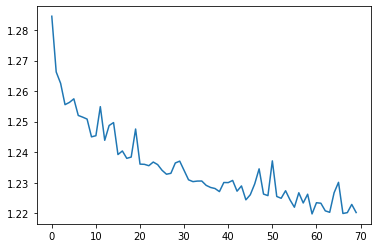

In [60]:
plt.plot(history.history['val_loss'])

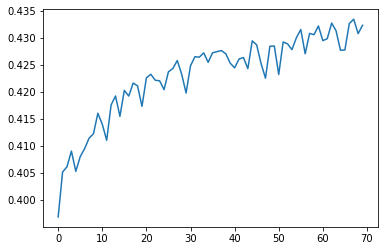

In [61]:
plt.plot(history.history['val_accuracy'])

In [23]:
from keras.models import Model
from keras.layers import Input
from keras.layers import Dense
embedding_size = 300

input = Input(shape = (261,1))
#embed = Embedding(4, embedding_size, mask_zero = True, input_length = 261)(input)
rnn1 = SimpleRNN(64, return_sequences=False)(input)
output = Dense(4, activation='softmax')(rnn1)
model = Model(inputs=input, outputs=output)
# summarize layers
print(model.summary())

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 261, 1)]          0         
                                                                 
 simple_rnn (SimpleRNN)      (None, 64)                4224      
                                                                 
 dense (Dense)               (None, 4)                 260       
                                                                 
Total params: 4,484
Trainable params: 4,484
Non-trainable params: 0
_________________________________________________________________
None


In [25]:
model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

In [27]:
history = model.fit(train_data, validation_data=test_data, epochs = 100, callbacks=callback)

Epoch 1/100
1501/1501 [==============================] - ETA: 0s - loss: 1.3928 - accuracy: 0.2477
Epoch 1: val_loss improved from inf to 1.39220, saving model to best_model.h5
1501/1501 [==============================] - 500s 333ms/step - loss: 1.3928 - accuracy: 0.2477 - val_loss: 1.3922 - val_accuracy: 0.2492
Epoch 2/100
1501/1501 [==============================] - ETA: 0s - loss: 1.3917 - accuracy: 0.2495
Epoch 2: val_loss improved from 1.39220 to 1.39150, saving model to best_model.h5
1501/1501 [==============================] - 490s 327ms/step - loss: 1.3917 - accuracy: 0.2495 - val_loss: 1.3915 - val_accuracy: 0.2488
Epoch 3/100
1501/1501 [==============================] - ETA: 0s - loss: 1.3912 - accuracy: 0.2491
Epoch 3: val_loss improved from 1.39150 to 1.38919, saving model to best_model.h5
1501/1501 [==============================] - 496s 331ms/step - loss: 1.3912 - accuracy: 0.2491 - val_loss: 1.3892 - val_accuracy: 0.2493
Epoch 4/100
1501/1501 [===========================

KeyboardInterrupt: 

In [ ]:
plt.plot(history.history['val_loss'])

In [ ]:
plt.plot(history.history['val_accuracy'])

In [28]:
from keras.models import Model
from keras.layers import Input
from keras.layers import Dense
embedding_size = 300

input = Input(shape = (261,1))
#embed = Embedding(4, embedding_size, mask_zero = True, input_length = 261)(input)
rnn1 = tf.keras.layers.GRU(64, return_sequences=False)(input)
output = Dense(4, activation='softmax')(rnn1)
model = Model(inputs=input, outputs=output)
# summarize layers
print(model.summary())

Model: "model_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_2 (InputLayer)        [(None, 261, 1)]          0         
                                                                 
 gru (GRU)                   (None, 64)                12864     
                                                                 
 dense_1 (Dense)             (None, 4)                 260       
                                                                 
Total params: 13,124
Trainable params: 13,124
Non-trainable params: 0
_________________________________________________________________
None


In [29]:
model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

In [32]:
history = model.fit(train_data, validation_data=test_data, epochs = 20, callbacks=callback)

Epoch 1/20
1501/1501 [==============================] - ETA: 0s - loss: 1.3862 - accuracy: 0.2478
Epoch 1: val_loss improved from 1.38625 to 1.38608, saving model to best_model.h5
1501/1501 [==============================] - 52s 34ms/step - loss: 1.3862 - accuracy: 0.2478 - val_loss: 1.3861 - val_accuracy: 0.2507
Epoch 2/20
1500/1501 [============================>.] - ETA: 0s - loss: 1.1849 - accuracy: 0.3964
Epoch 2: val_loss improved from 1.38608 to 1.03121, saving model to best_model.h5
1501/1501 [==============================] - 50s 33ms/step - loss: 1.1848 - accuracy: 0.3965 - val_loss: 1.0312 - val_accuracy: 0.5012
Epoch 3/20
1499/1501 [============================>.] - ETA: 0s - loss: 1.0279 - accuracy: 0.5250
Epoch 3: val_loss improved from 1.03121 to 1.02201, saving model to best_model.h5
1501/1501 [==============================] - 50s 33ms/step - loss: 1.0280 - accuracy: 0.5250 - val_loss: 1.0220 - val_accuracy: 0.5218
Epoch 4/20
1499/1501 [============================>.] -

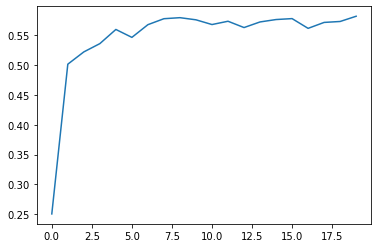

In [33]:
plt.plot(history.history['val_accuracy'])

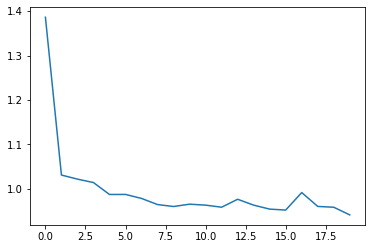

In [34]:
plt.plot(history.history['val_loss'])

In [35]:
from keras.models import Model
from keras.layers import Input
from keras.layers import Dense
embedding_size = 300

input = Input(shape = (261,1))
#embed = Embedding(4, embedding_size, mask_zero = True, input_length = 261)(input)
rnn1 = tf.keras.layers.LSTM(64, return_sequences=False)(input)
output = Dense(4, activation='softmax')(rnn1)
model = Model(inputs=input, outputs=output)
# summarize layers
print(model.summary())

Model: "model_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_3 (InputLayer)        [(None, 261, 1)]          0         
                                                                 
 lstm (LSTM)                 (None, 64)                16896     
                                                                 
 dense_2 (Dense)             (None, 4)                 260       
                                                                 
Total params: 17,156
Trainable params: 17,156
Non-trainable params: 0
_________________________________________________________________
None


In [36]:
model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

In [37]:
history = model.fit(train_data, validation_data=test_data, epochs = 20, callbacks=callback)

Epoch 1/20
1500/1501 [============================>.] - ETA: 0s - loss: 1.3866 - accuracy: 0.2475
Epoch 1: val_loss did not improve from 0.94155
1501/1501 [==============================] - 55s 37ms/step - loss: 1.3866 - accuracy: 0.2475 - val_loss: 1.3824 - val_accuracy: 0.2618
Epoch 2/20
1499/1501 [============================>.] - ETA: 0s - loss: 1.0738 - accuracy: 0.4996
Epoch 2: val_loss did not improve from 0.94155
1501/1501 [==============================] - 54s 36ms/step - loss: 1.0735 - accuracy: 0.4999 - val_loss: 1.0063 - val_accuracy: 0.5433
Epoch 3/20
1499/1501 [============================>.] - ETA: 0s - loss: 1.0008 - accuracy: 0.5560
Epoch 3: val_loss did not improve from 0.94155
1501/1501 [==============================] - 54s 36ms/step - loss: 1.0009 - accuracy: 0.5560 - val_loss: 0.9826 - val_accuracy: 0.5718
Epoch 4/20
1499/1501 [============================>.] - ETA: 0s - loss: 0.9898 - accuracy: 0.5605
Epoch 4: val_loss did not improve from 0.94155
1501/1501 [====

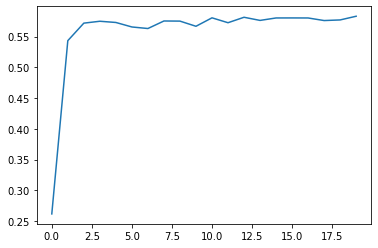

In [38]:
plt.plot(history.history['val_accuracy'])

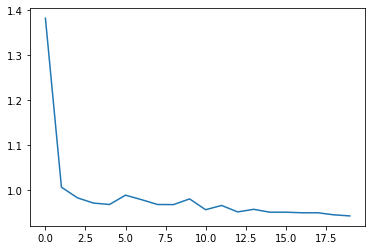

In [39]:
plt.plot(history.history['val_loss'])

In [40]:
postpad_X = sequence.pad_sequences(X_train, padding='pre', maxlen = max_words, dtype='float')
postpad_X = np.expand_dims(postpad_X,axis=2)
postpad_X_test = sequence.pad_sequences(X_test, padding='pre', maxlen = max_words, dtype='float')
postpad_X_test = np.expand_dims(postpad_X_test,axis=2)

In [41]:
train_data = tf.data.Dataset.from_tensor_slices((postpad_X,y_train))
train_data = train_data.shuffle(buffer_size=len(postpad_X))
train_data = train_data.batch(32)
train_data = train_data.prefetch(AUTOTUNE)

In [42]:
test_data = tf.data.Dataset.from_tensor_slices((postpad_X_test,y_test))
test_data = train_data.batch(32)
test_data = train_data.prefetch(AUTOTUNE)

In [46]:
from keras.models import Model
from keras.layers import Input
from keras.layers import Dense
embedding_size = 300

input = Input(shape = (261,1))
#embed = Embedding(4, embedding_size, mask_zero = True, input_length = 261)(input)
rnn1 = SimpleRNN(64, return_sequences=False)(input)
output = Dense(4, activation='softmax')(rnn1)
model = Model(inputs=input, outputs=output)
# summarize layers
print(model.summary())

Model: "model_4"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_5 (InputLayer)        [(None, 261, 1)]          0         
                                                                 
 simple_rnn_2 (SimpleRNN)    (None, 64)                4224      
                                                                 
 dense_4 (Dense)             (None, 4)                 260       
                                                                 
Total params: 4,484
Trainable params: 4,484
Non-trainable params: 0
_________________________________________________________________
None


In [47]:
model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

In [48]:
history = model.fit(train_data, validation_data=test_data, epochs = 100, callbacks=callback)

Epoch 1/100
  17/1501 [..............................] - ETA: 5:26 - loss: 1.4138 - accuracy: 0.2978

KeyboardInterrupt: 

In [ ]:
plt.plot(history.history['val_loss'])

In [ ]:
plt.plot(history.history['val_accuracy'])